Configure um ambiente virtual python conforme o arquivo requirements. 

In [2]:
%pip install tensorflow
%pip install matplotlib
%pip install opencv-python
%pip install seaborn
%pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
import random
import cv2
from tensorflow.keras import layers
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
def process_image(image_path, crop_params, output_size):
    try:

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width = img_rgb.shape[:2]

        # Define limites do corte, com segurança para não ultrapassar as bordas
        y1 = min(crop_params["top"], height)
        y2 = max(height - crop_params["bottom"], 0)
        x1 = min(crop_params["left"], width)
        x2 = max(width - crop_params["right"], 0)

        # Realiza o corte
        cropped = img_rgb[y1:y2, x1:x2]
        
        # Redimensiona para o tamanho desejado (ex: 160x160)
        resized = cv2.resize(cropped, output_size, interpolation=cv2.INTER_AREA)

        return resized

    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

In [5]:
# Caminho base do dataset
dataset_dir = os.path.join('..', 'data', 'raw', 'dice_rolls')

# Inicializa os dicionários
dataset_train_len = defaultdict(int)
dataset_validation_len = defaultdict(int)

# Rótulos numéricos, com nome de pasta
class_names = ['1_one', '2_two', '3_three', '4_four',
          '5_five', '6_six', '7_seven', '8_eight']

crop_params = {
    "top": 1200,
    "bottom": 800,
    "left": 400,
    "right": 400
}

processed_image_size = (160, 160)

# Semente para reprodutibilidade
random.seed(42)

# Percorre cada rótulo
for label in class_names:
    label_dir = os.path.join(dataset_dir, label)
    
    if not os.path.isdir(label_dir):
        continue
    
    # Lista para todas as imagens desse rótulo, independente do tipo de dado
    all_images = []

    # Percorre cada subpasta de tipo de dado (d4, d6, etc.)
    for dice_type in os.listdir(label_dir):
        dice_path = os.path.join(label_dir, dice_type)
        if not os.path.isdir(dice_path):
            continue
        
        # Caminho completo das imagens
        for img in os.listdir(dice_path):
            full_path = os.path.join(dice_path, img)
            if os.path.isfile(full_path):
                all_images.append(full_path)

    # Embaralha e divide 80% treino / 20% validação
    random.shuffle(all_images)
    total = len(all_images)
    split_index = int(0.8 * total)

    train_images = all_images[:split_index]
    validation_images = all_images[split_index:]

    dataset_train_len[label] = len(train_images)
    dataset_validation_len[label] = len(validation_images)

    # Cria pastas de saída
    processed_train_dir = os.path.join('..', 'data', 'processed', 'train', label)
    processed_val_dir = os.path.join('..', 'data', 'processed', 'validation', label)
    os.makedirs(processed_train_dir, exist_ok=True)
    os.makedirs(processed_val_dir, exist_ok=True)
    
    for i, img_path in enumerate(train_images):
        processed = process_image(img_path, crop_params, processed_image_size)
        if processed is not None:
            output_path = os.path.join(processed_train_dir, f"{label}_{i}.jpg")
            cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))

    for i, img_path in enumerate(validation_images):
        processed = process_image(img_path, crop_params, processed_image_size)
        if processed is not None:
            output_path = os.path.join(processed_val_dir, f"{label}_{i}.jpg")
            cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
    

# Impressão dos resultados
print("Imagens de Treinamento:")
for label, count in dataset_train_len.items():
    print(f"  {label}: {count} imagens")

print("\nImagens de Validação:")
for label, count in dataset_validation_len.items():
    print(f"  {label}: {count} imagens")

Imagens de Treinamento:
  1_one: 143 imagens
  2_two: 133 imagens
  3_three: 139 imagens
  4_four: 136 imagens
  5_five: 112 imagens
  6_six: 96 imagens
  7_seven: 68 imagens
  8_eight: 69 imagens

Imagens de Validação:
  1_one: 36 imagens
  2_two: 34 imagens
  3_three: 35 imagens
  4_four: 35 imagens
  5_five: 28 imagens
  6_six: 24 imagens
  7_seven: 18 imagens
  8_eight: 18 imagens


In [6]:
image_color_channel = 3
image_color_channel_size = 255
image_shape = processed_image_size + (image_color_channel,)

batch_size = 32
epochs = 40
learning_rate = 0.0006

dataset_train_dir = os.path.join('..', 'data', 'processed', 'train')
dataset_validation_dir = os.path.join('..', 'data', 'processed', 'validation')

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size=processed_image_size,
    batch_size=batch_size,
    shuffle=True,
    label_mode='int'
)

dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size=processed_image_size,
    batch_size=batch_size,
    shuffle=True,
    label_mode='int'
)

class_names = dataset_train.class_names

Found 1009 files belonging to 8 classes.
Found 228 files belonging to 8 classes.


In [7]:
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')
            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            

<Figure size 640x480 with 0 Axes>

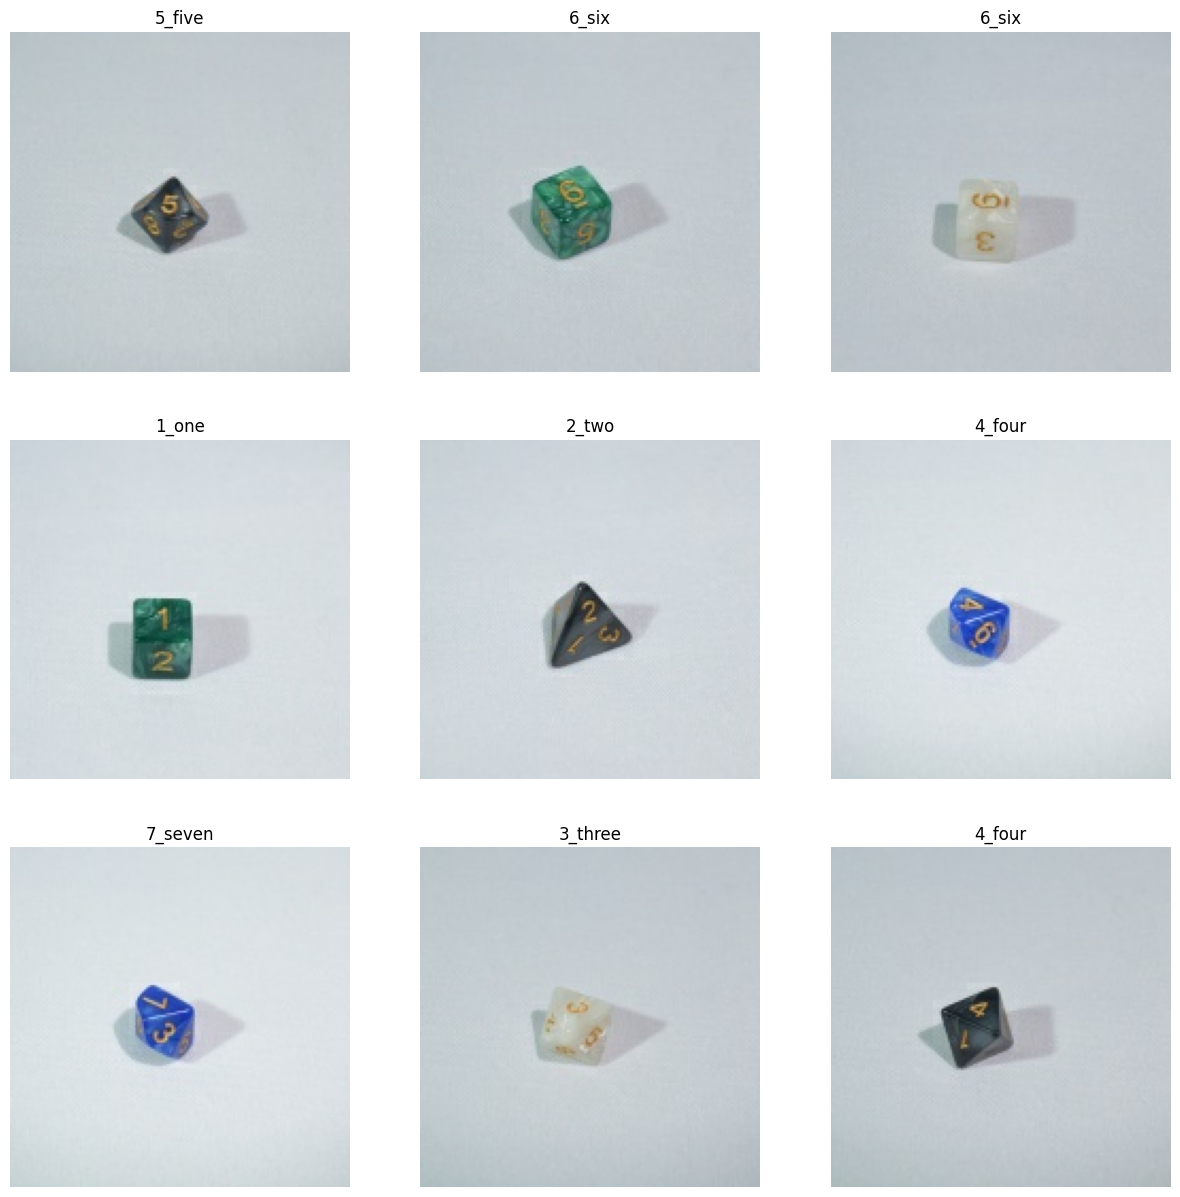

In [8]:
plot_dataset(dataset_train)

<Figure size 640x480 with 0 Axes>

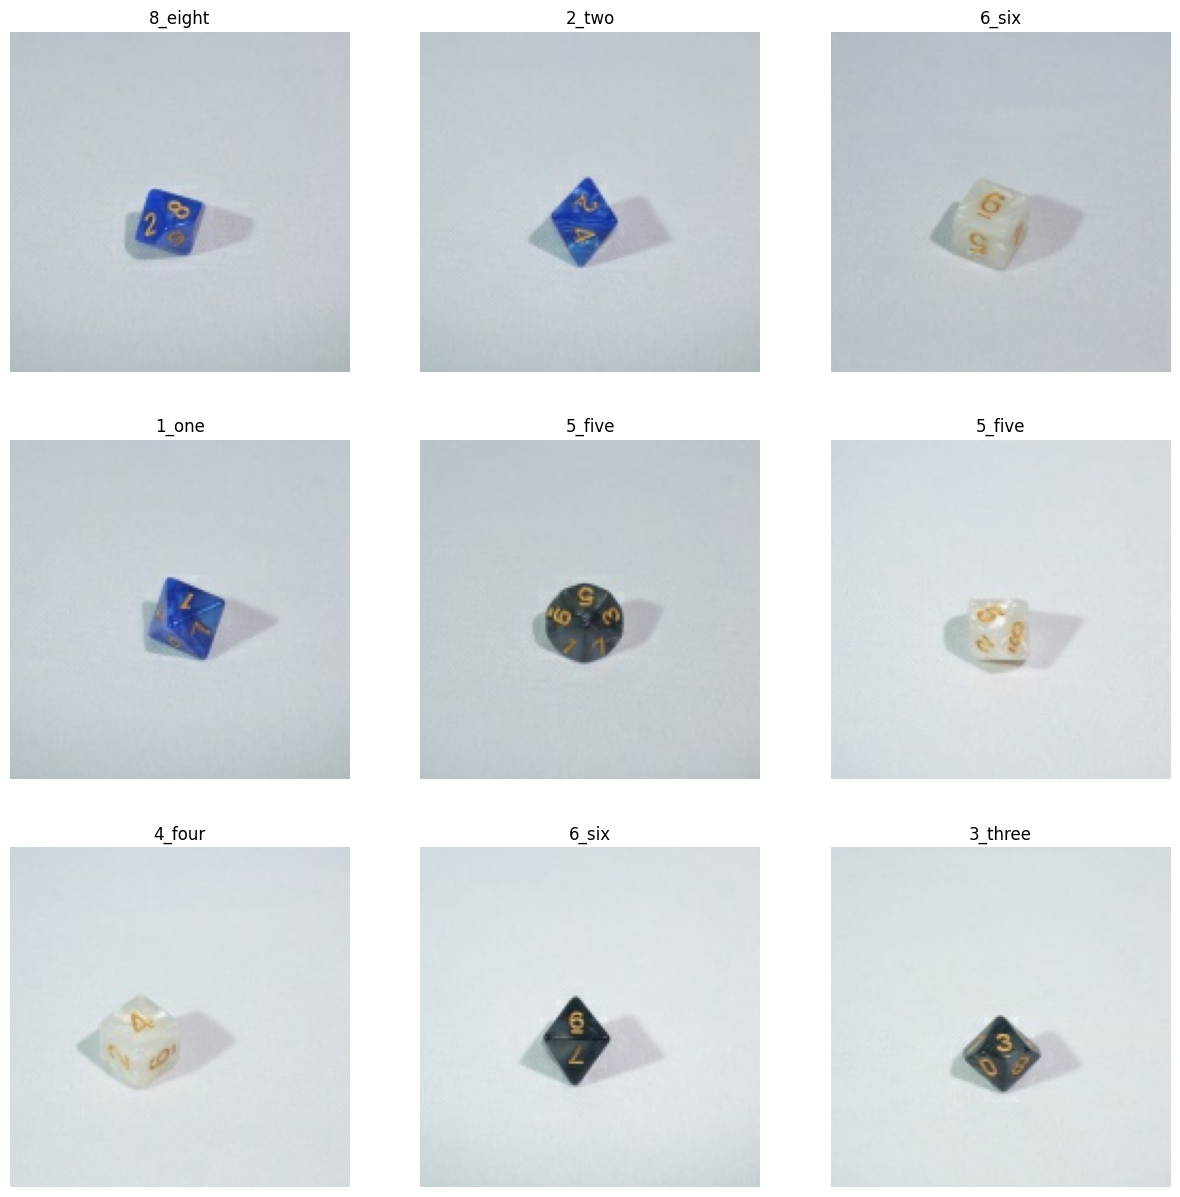

In [9]:
plot_dataset(dataset_validation)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(
        1. / image_color_channel_size,
        input_shape=image_shape
    ),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

d:\projeto-tcc\venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,544 (12.59 MB)

 Trainable params: 3,301,544 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    dataset_train,
    validation_data=dataset_validation,
    epochs=epochs
)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.1323 - loss: 2.1072 - val_accuracy: 0.1535 - val_loss: 2.0474
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.1468 - loss: 2.0491 - val_accuracy: 0.1535 - val_loss: 2.0411
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.1698 - loss: 2.0333 - val_accuracy: 0.1930 - val_loss: 1.9957
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.2051 - loss: 1.9848 - val_accuracy: 0.2500 - val_loss: 1.9260
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.2405 - loss: 1.9122 - val_accuracy: 0.2456 - val_loss: 1.8844
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.2924 - loss: 1.8183 - val_accuracy: 0.2807 - val_loss: 1.8153
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.3228 - loss: 1.7582 - val_accuracy: 0.2544 - val_loss: 1.8432
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.3153 - loss: 1.7493 - val_accuracy: 0

In [12]:
def plot_predictions_with_labels(dataset, num_images):
    features, labels = dataset.as_numpy_iterator().next()

    # Garante que não exagere na quantidade de imagens do batch
    num_images = min(num_images, features.shape[0])

    predictions_prob = model.predict_on_batch(features[:num_images]).flatten()
    predictions = tf.where(predictions_prob < 0.5, 0, 1).numpy()

    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.axis('off')
        
        plt.imshow(features[i].astype('uint8'))

        true_label = labels[i]
        pred_label = predictions[i]

        title_color = 'green' if true_label == pred_label else 'red'
        title_text = f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}'

        plt.title(title_text, color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_confusion_matrix_with_accuracy(dataset, model, class_names):
    y_true = []
    y_pred = []

    for batch_images, batch_labels in dataset:
        predictions = model.predict(batch_images)
        pred_classes = np.argmax(predictions, axis=1)

        y_true.extend(batch_labels.numpy())
        y_pred.extend(pred_classes)

    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

    # Acurácia por classe
    print("\n🎯 Acurácia por classe:")
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for i, class_name in enumerate(class_names):
        class_mask = (y_true == i)
        class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
        print(f"{class_name}: {class_accuracy:.2%}")

In [14]:
def plot_training_history(history):
    # history é o objeto retornado por model.fit
    acc = history.history.get('accuracy', None) or history.history.get('acc', None)
    val_acc = history.history.get('val_accuracy', None) or history.history.get('val_acc', None)
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot de acurácia
    plt.subplot(1, 2, 1)
    if acc:
        plt.plot(epochs, acc, 'b-', label='Acurácia treino')
    if val_acc:
        plt.plot(epochs, val_acc, 'r--', label='Acurácia validação')
    plt.title('Acurácia durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    # Plot de loss (erro)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Loss treino')
    plt.plot(epochs, val_loss, 'r--', label='Loss validação')
    plt.title('Loss durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

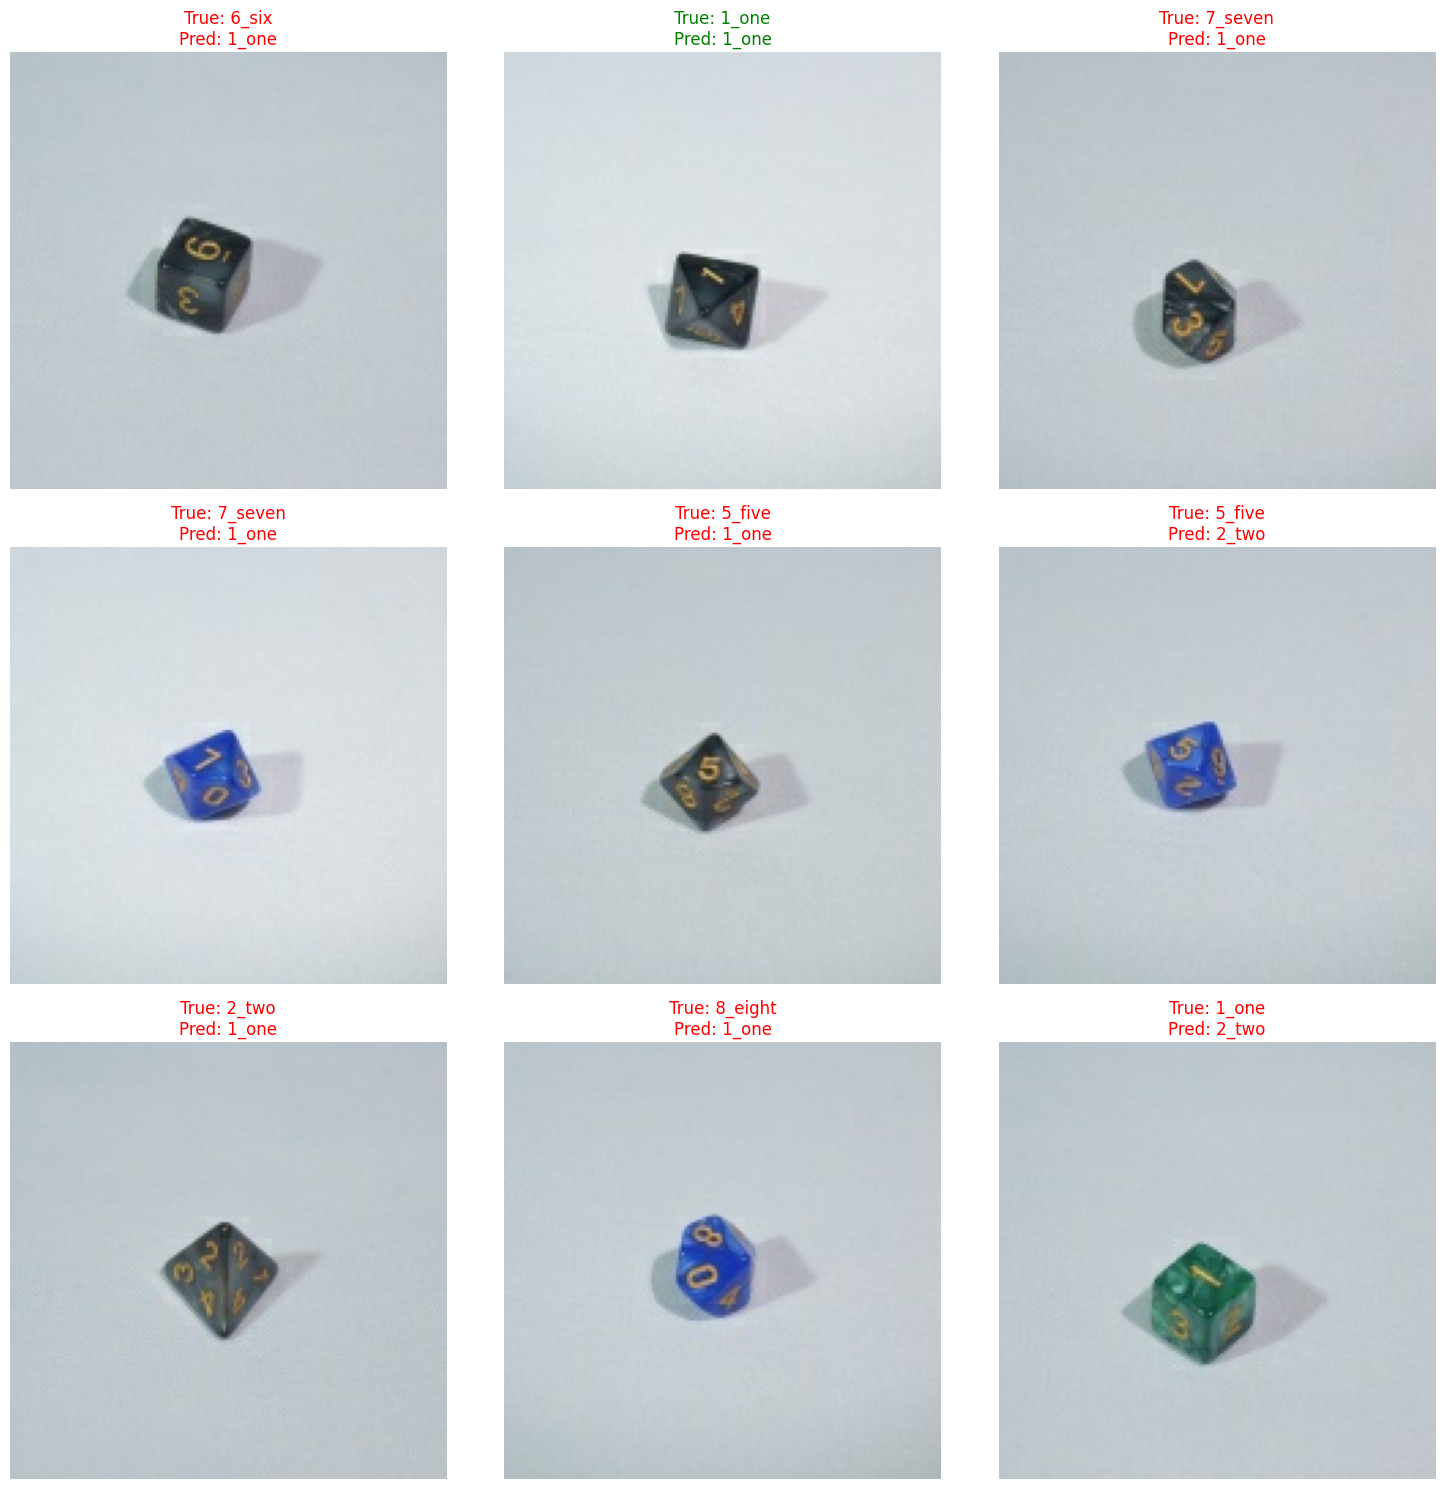

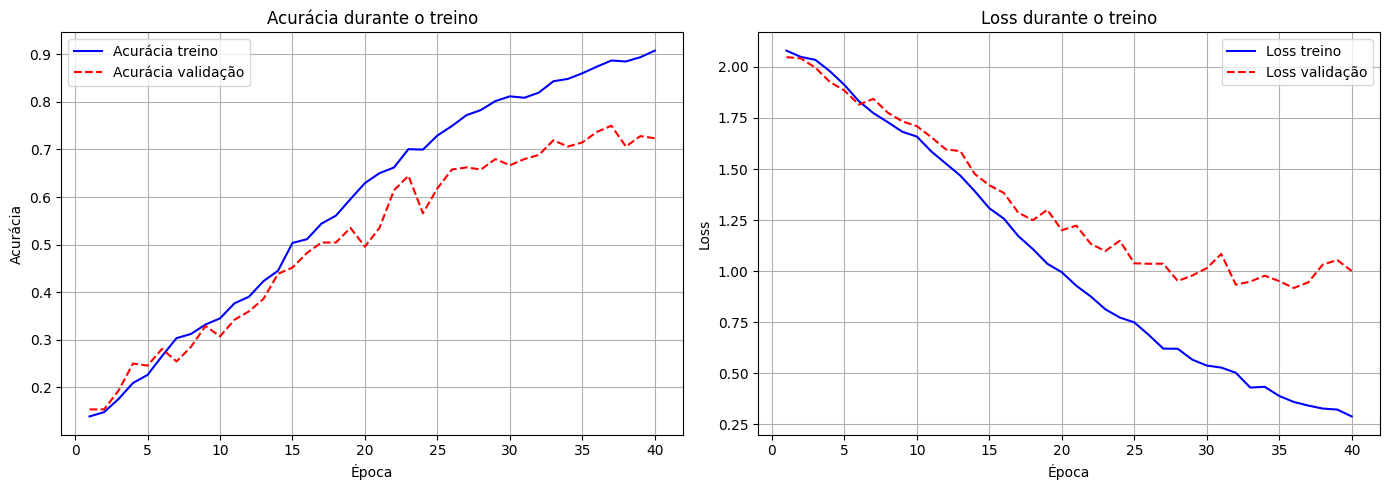

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


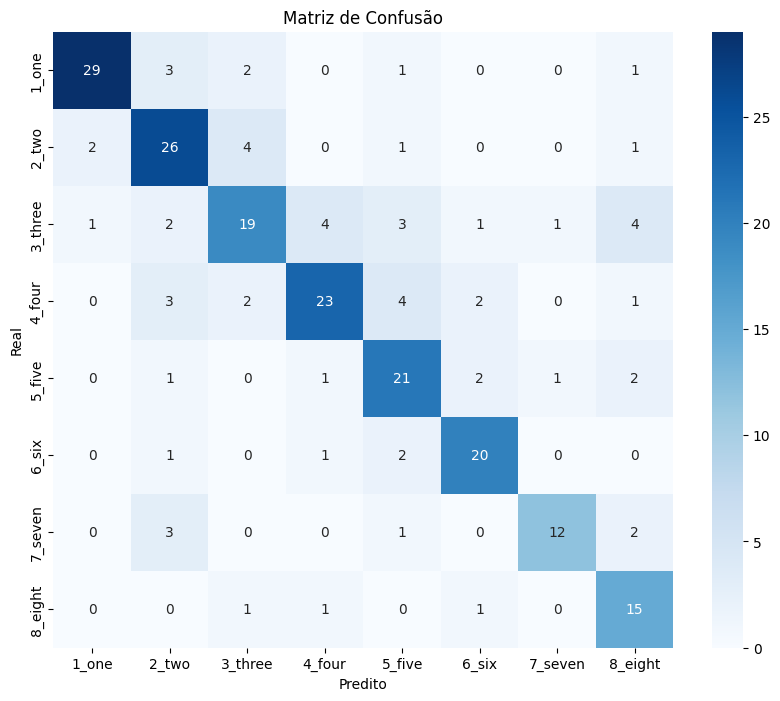


🎯 Acurácia por classe:
1_one: 80.56%
2_two: 76.47%
3_three: 54.29%
4_four: 65.71%
5_five: 75.00%
6_six: 83.33%
7_seven: 66.67%
8_eight: 83.33%


In [15]:
plot_predictions_with_labels(dataset_validation, num_images=9)
plot_training_history(history)
plot_confusion_matrix_with_accuracy(dataset_validation, model, class_names)